In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

#### Configuración de tema matplotlib

In [17]:
plt.style.use('seaborn-v0_8-pastel')

#### Conexión a BD

In [ ]:
with open('../config/lyft_conection.json', 'r') as file:
    credenciales_lyft = json.load(file)

In [ ]:

engine = create_engine(f"mysql+pymysql://{credenciales_lyft['USERNAME']}:{credenciales_lyft['PASSWORD']}@{credenciales_lyft['SERVER']}/{credenciales_lyft['DATABASE']}")

#### Total de suscriptores activos

In [19]:
sql_active_users = f'''

SELECT
    COUNT(DISTINCT member_accountNumber) as total_usuarios
FROM BikeRentalFact
WHERE 
    (startTimeMs BETWEEN UNIX_TIMESTAMP(CONVERT_TZ("2025-01-01 00:00:00", "America/Mexico_City", 'UTC'))*1000 
    AND UNIX_TIMESTAMP(CONVERT_TZ("2025-10-31 23:59:59", "America/Mexico_City", 'UTC'))*1000)
    AND NOT ((startStation_id = endStation_id) AND (duration/60 < 2));

'''

df_active_users = pd.read_sql(sql_active_users, engine)
df_active_users.head()

,total_usuarios
0,292641


In [20]:
sql_no_active_users = f'''

SELECT
    COUNT(DISTINCT member_accountNumber) as total_usuarios
FROM BikeRentalFact
WHERE 
    (startTimeMs BETWEEN UNIX_TIMESTAMP(CONVERT_TZ("2025-01-01 00:00:00", "America/Mexico_City", 'UTC'))*1000 
    AND UNIX_TIMESTAMP(CONVERT_TZ("2025-10-31 23:59:59", "America/Mexico_City", 'UTC'))*1000)
    AND ((startStation_id = endStation_id) AND (duration/60 < 2));

'''

df_no_active_users = pd.read_sql(sql_no_active_users, engine)
df_no_active_users.head()

,total_usuarios
0,118965


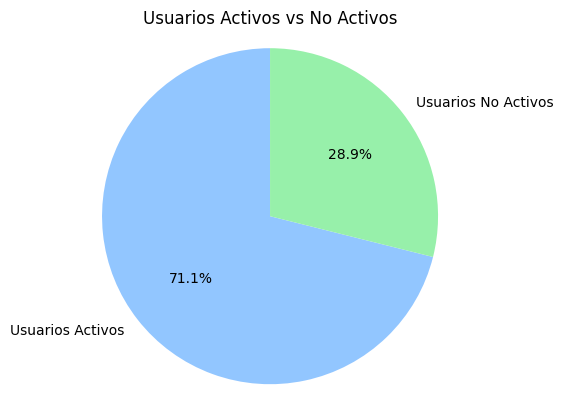

In [21]:
# graficar usuarios activos vs no activos
labels = ['Usuarios Activos', 'Usuarios No Activos']
sizes = [df_active_users['total_usuarios'][0], df_no_active_users['total_usuarios'][0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Usuarios Activos vs No Activos')
plt.show()

#### Tasa de renovación de suscripciones

In [22]:
sql_suscripciones = f'''

SELECT
    member_accountNumber,
    purchase,
    start,
    end,
    status_id,
    subscriptionType_id,
    member_birthday,
    member_country,
    member_gender,
    member_language,
    member_postalCode,
    discountCodeRedemptionNumber,
    purchasePrice,
    totalPaid,
    nextSubscriptionId,
    previousSubscriptionId
FROM BikeSubscriptionFact
WHERE 
    (purchase BETWEEN UNIX_TIMESTAMP(CONVERT_TZ("2025-01-01 00:00:00", "America/Mexico_City", 'UTC'))*1000 
    AND UNIX_TIMESTAMP(CONVERT_TZ("2025-10-31 23:59:59", "America/Mexico_City", 'UTC'))*1000);

'''

df_suscripciones_sql = pd.read_sql(sql_suscripciones, engine)
df_suscripciones_sql.head()

,member_accountNumber,purchase,start,end,status_id,subscriptionType_id,member_birthday,member_country,member_gender,member_language,member_postalCode,discountCodeRedemptionNumber,purchasePrice,totalPaid,nextSubscriptionId,previousSubscriptionId
0,419648,1735711210812,1735883999000,1767419999000,0,4,3.414744e+11,MX,M,es,01180,None,469.83,545.0,NaN,352811.0
1,423139,1735711213620,1735883999000,1767419999000,0,4,7.782264e+11,MX,F,es,03900,None,469.83,545.0,NaN,352812.0
2,424175,1735711216984,1735883999000,1767419999000,0,4,-4.626504e+11,MX,M,es,01000,None,469.83,545.0,NaN,352814.0
3,428219,1735711222183,1735883999000,1767419999000,0,4,6.478488e+11,MX,F,es,06100,None,469.83,545.0,NaN,352816.0
4,485256,1735711223991,1735883999000,1767419999000,0,4,7.604280e+11,MX,F,es,03100,None,469.83,545.0,NaN,352817.0


In [23]:
# tasa de renovación de suscripciones por mee
total_suscripciones = df_suscripciones_sql.shape[0]
renovaciones = df_suscripciones_sql['nextSubscriptionId'].notnull().sum()
tasa_renovacion = (renovaciones / total_suscripciones) * 100
print(f'Tasa de renovación de suscripciones: {tasa_renovacion:.2f}%')

Tasa de renovación de suscripciones: 9.46%


In [24]:
sql_subscriptions_info = f'''

SELECT
    id,
    name_localizedValue1
FROM BikeSubscriptionTypeDim;

'''

df_subscriptions_info = pd.read_sql(sql_subscriptions_info, engine)
df_subscriptions_info.head()

,id,name_localizedValue1
0,1,1 Día (I.V.A incluido)
1,2,3 Días (I.V.A incluido)
2,3,7 Días (I.V.A incluido)
3,4,Anual (I.V.A incluido)
4,9,Anual Ecobici+ (I.V.A incluido)


In [25]:
# unir info de suscripciones con df_suscripciones_sql
df_suscripciones = df_suscripciones_sql.merge(df_subscriptions_info, left_on='subscriptionType_id', right_on='id', how='left')
df_suscripciones.head()

,member_accountNumber,purchase,start,end,status_id,subscriptionType_id,member_birthday,member_country,member_gender,member_language,member_postalCode,discountCodeRedemptionNumber,purchasePrice,totalPaid,nextSubscriptionId,previousSubscriptionId,id,name_localizedValue1
0,419648,1735711210812,1735883999000,1767419999000,0,4,3.414744e+11,MX,M,es,01180,None,469.83,545.0,NaN,352811.0,4,Anual (I.V.A incluido)
1,423139,1735711213620,1735883999000,1767419999000,0,4,7.782264e+11,MX,F,es,03900,None,469.83,545.0,NaN,352812.0,4,Anual (I.V.A incluido)
2,424175,1735711216984,1735883999000,1767419999000,0,4,-4.626504e+11,MX,M,es,01000,None,469.83,545.0,NaN,352814.0,4,Anual (I.V.A incluido)
3,428219,1735711222183,1735883999000,1767419999000,0,4,6.478488e+11,MX,F,es,06100,None,469.83,545.0,NaN,352816.0,4,Anual (I.V.A incluido)
4,485256,1735711223991,1735883999000,1767419999000,0,4,7.604280e+11,MX,F,es,03100,None,469.83,545.0,NaN,352817.0,4,Anual (I.V.A incluido)


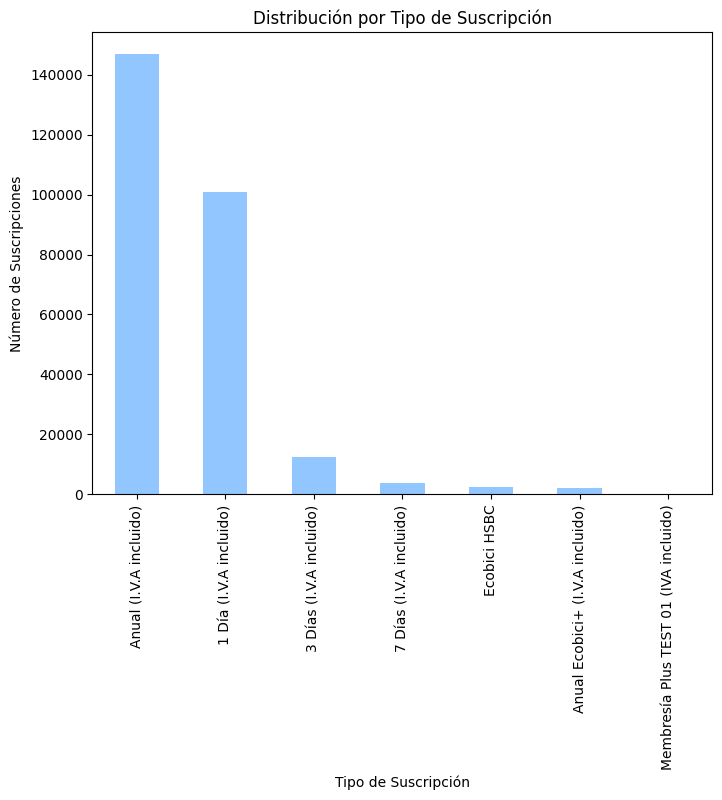

In [26]:
# Distribución por tipo de suscripción (anual, mensual, ocasional)
subscription_counts = df_suscripciones['name_localizedValue1'].value_counts()
plt.figure(figsize=(8, 6))
subscription_counts.plot(kind='bar')
plt.title('Distribución por Tipo de Suscripción')
plt.xlabel('Tipo de Suscripción')
plt.ylabel('Número de Suscripciones')
plt.show()


In [27]:
# Tasa de conversión de usuarios ocasionales a suscriptores
occasional_to_subscriber = df_suscripciones[df_suscripciones['name_localizedValue1'] == 'Ocasional'].shape[0]
total_occasional = df_suscripciones_sql.shape[0]
conversion_rate = (occasional_to_subscriber / total_occasional) * 100
print(f'Tasa de conversión de usuarios ocasionales a suscriptores: {conversion_rate:.2f}%')
#!/usr/bin/env python3

Tasa de conversión de usuarios ocasionales a suscriptores: 0.00%


C:\Users\victor.briones\AppData\Local\Temp\ipykernel_14008\929033628.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_subscriptions = df_suscripciones.resample('M').size()


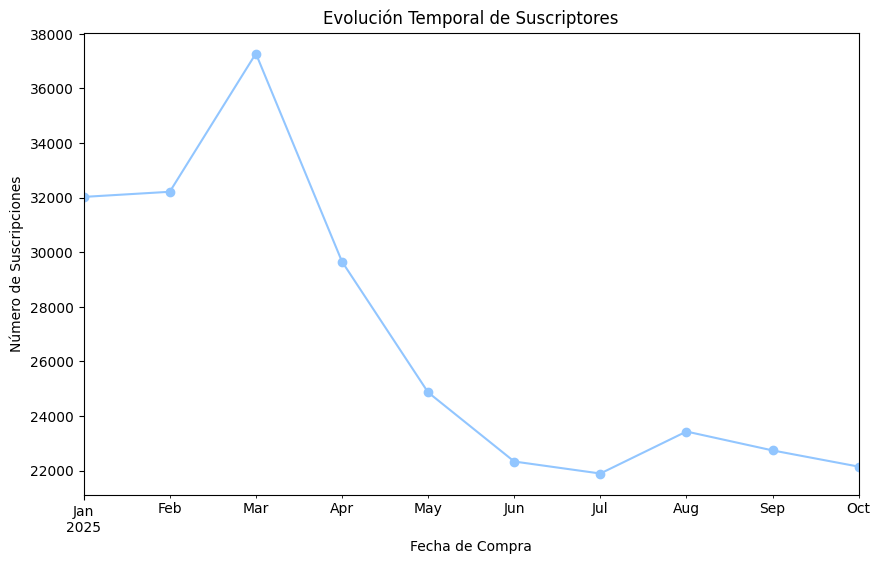

In [28]:
# Gráfico de líneas - Evolución temporal de suscriptores
df_suscripciones['purchase_date'] = pd.to_datetime(df_suscripciones['purchase'], unit='ms')
df_suscripciones.set_index('purchase_date', inplace=True)
monthly_subscriptions = df_suscripciones.resample('M').size()
plt.figure(figsize=(10, 6))
monthly_subscriptions.plot(kind='line', marker='o')
plt.title('Evolución Temporal de Suscriptores')
plt.xlabel('Fecha de Compra')
plt.ylabel('Número de Suscripciones')
plt.show()


C:\Users\victor.briones\AppData\Local\Temp\ipykernel_14008\2380160096.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  subscription_type_over_time = df_suscripciones.groupby([pd.Grouper(freq='M'), 'name_localizedValue1']).size().unstack().fillna(0)


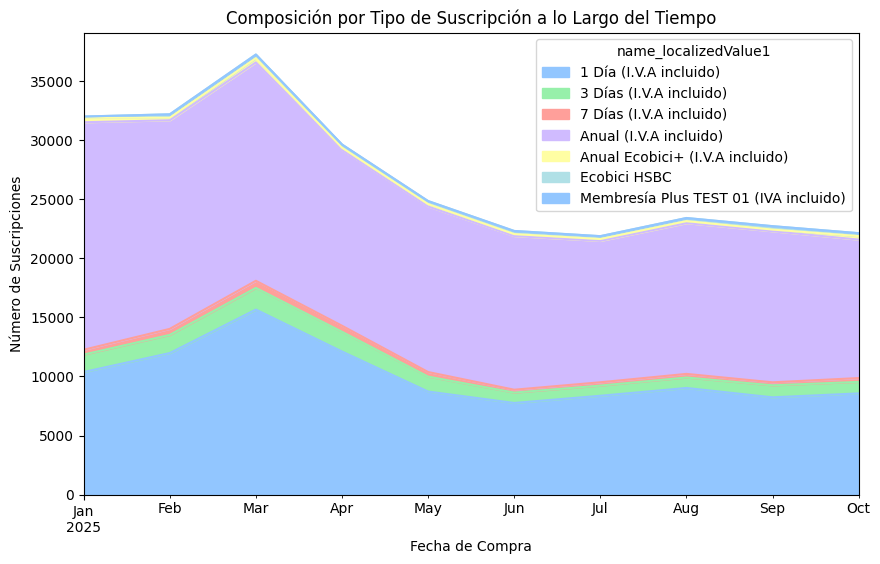

In [29]:
# Gráfico de áreas apiladas - Composición por tipo de suscripción
subscription_type_over_time = df_suscripciones.groupby([pd.Grouper(freq='M'), 'name_localizedValue1']).size().unstack().fillna(0)
subscription_type_over_time.plot(kind='area', stacked=True, figsize=(10, 6))
plt.title('Composición por Tipo de Suscripción a lo Largo del Tiempo')
plt.xlabel('Fecha de Compra')
plt.ylabel('Número de Suscripciones')
plt.show()
# Gráfico de áreas apiladas - Composición por tipo de suscripción